# MNIST Dataset | Convolutional Neural Networks with Keras
If you want to apply machine learning to image recognition, convolutional neural networks (CNN) is the way to go. It has been sweeping the board in competitions for the last several years, but perhaps its first big success came in the late 90's when Yann LeCun used it to solve MNIST with 99.5% accuracy. I will show you how it is done in Keras, which is a user-friendly neural network library for python.

Many other notebooks here use a simple fully-connected network (no convolution) to achieve 96-97%, which is a poor result on this dataset. In contrast, what I will show you here is nearly state-of-the-art. In the Kernel with less than 20 minutes training we will achieve 99%, but if you train it overnight (or with a GPU) you should reach 99.5. If you then ensemble over several runs, you should get close to the best published accuracy of 99.77%.

## Data Preparation
### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Import Training and Test sets

In [2]:
train_df = pd.read_csv('input/train.csv', header=0)
test_df = pd.read_csv('input/test.csv', header=0)
print('Training set consists of {} observations and {} columns.'.format(train_df.shape[0], train_df.shape[1]))
print('Test set consists of {} observations and {} columns.'.format(test_df.shape[0], test_df.shape[1]))

Training set consists of 42000 observations and 785 columns.
Test set consists of 28000 observations and 784 columns.


### Transform Training and Test sets to Numpy arrays

In [3]:
X_train = train_df.iloc[:, 1:].as_matrix()
y_train = train_df.iloc[:, 0].values.reshape(-1, 1)
X_test = test_df.as_matrix()
print('X_train shape: {}\ny_train shape: {}\nX_test shape: {}'.format(
    X_train.shape, y_train.shape, X_test.shape))

X_train shape: (42000, 784)
y_train shape: (42000, 1)
X_test shape: (28000, 784)


### Plotting some Examples of Digits in Training Set
Here I plot the first 25 digits of the Training Set and their respective labels.

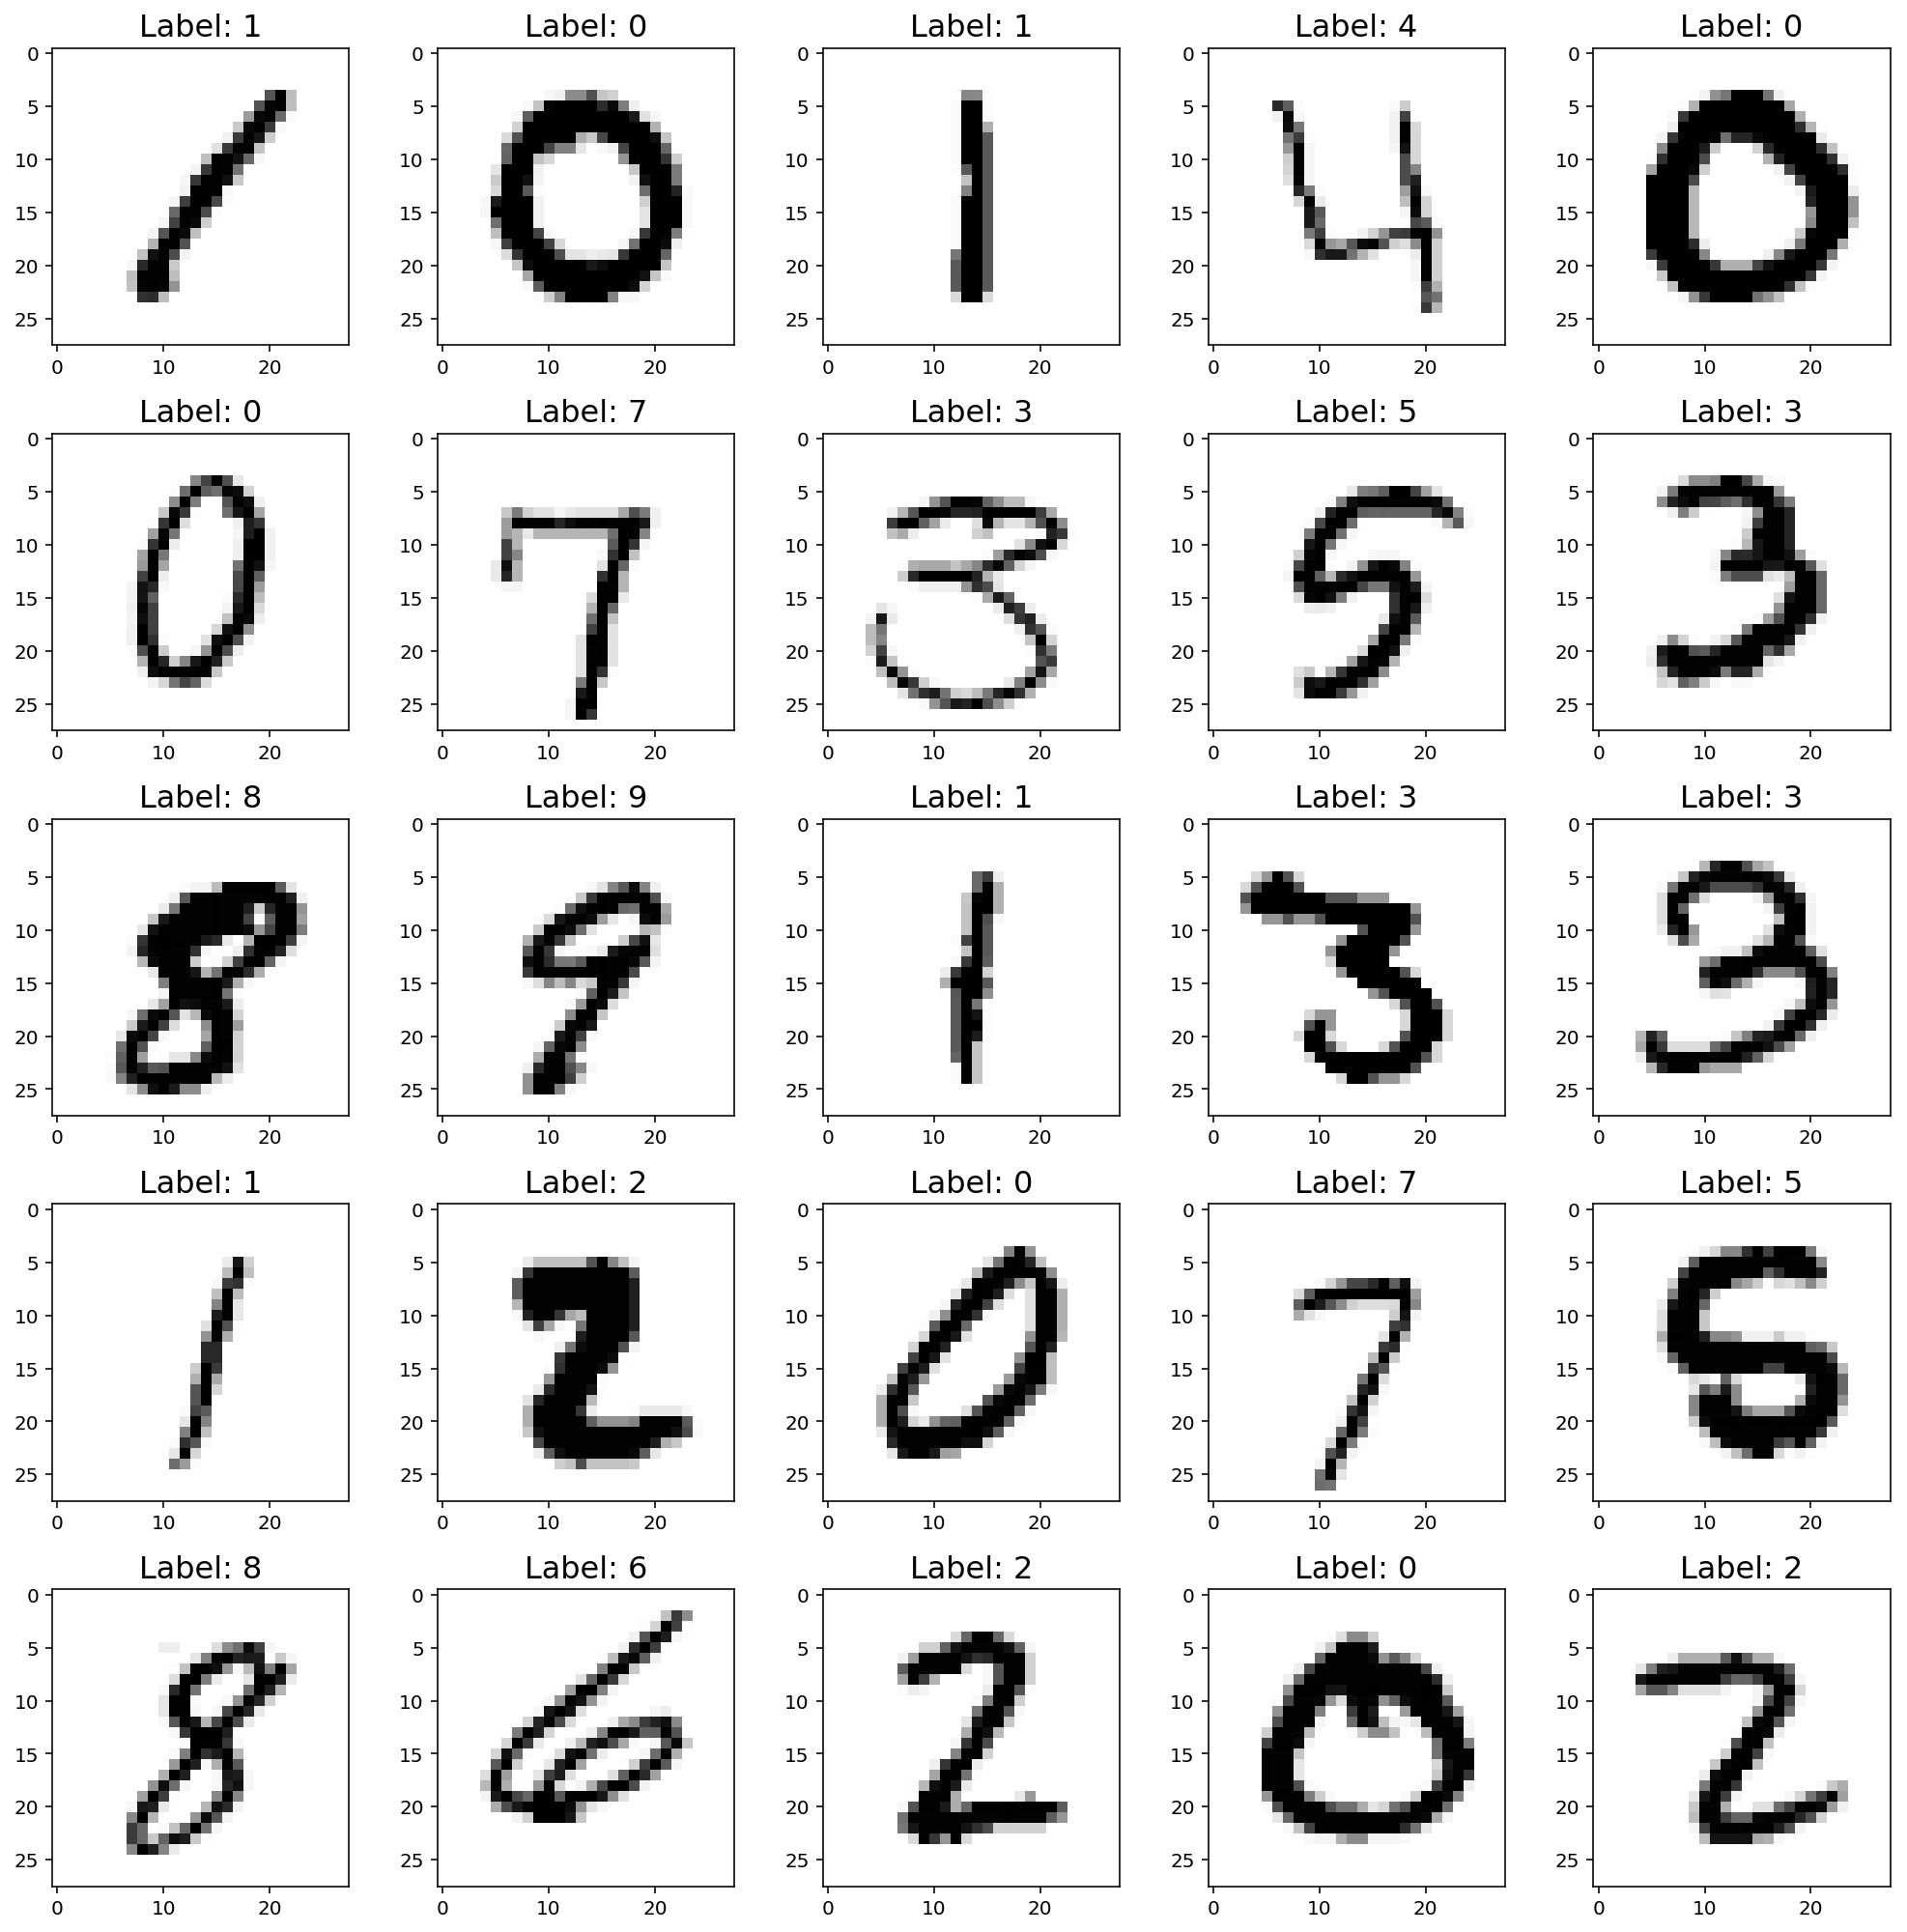

In [4]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
for i in range(nrows*ncols):
    ax[i//ncols, i%ncols].imshow(X_train[i, :].reshape(28, 28), cmap='Greys')
    ax[i//ncols, i%ncols].set_title('Label: {}'.format(int(y_train[i])), fontsize=16)
plt.tight_layout()

### Reshaping Training and Test set rows to [28x28x1] sized arrays

In [5]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_test = X_test.astype('float32')/255.

### Splitting Training Set into a new Training Set and a Validation Set
It is good practice to have a Validation Set to check the model predictions and improvement. Here I decided on a relatively small Validation Set size of 5%. Using Scikit-Learn's [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=555)

### Encoding Labels into [1x10] sized Arrays
The labels are encoded as one digit (0-9) per row. In order to work with the MNIST dataset I will need to one-hot encode them, into [1x10] sized Numpy arrays with one in the position whose index corresponds to the label, and zeros elsewhere. This is very easy to achieve using Scikit-Learn's [`OneHotEncoder()`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [7]:
from sklearn.preprocessing import OneHotEncoder

y_train = OneHotEncoder(sparse=False).fit_transform(y_train)
y_val = OneHotEncoder(sparse=False).fit_transform(y_val)

print('X_train shape: {}\ny_train shape: {}\nX_val shape: {}\ny_val shape: {}'.format(
    X_train.shape, y_train.shape, X_val.shape, y_val.shape))

X_train shape: (39900, 28, 28, 1)
y_train shape: (39900, 10)
X_val shape: (2100, 28, 28, 1)
y_val shape: (2100, 10)


## Building the CNN
### Importing the Keras Libraries

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, TerminateOnNaN, EarlyStopping, TensorBoard

Using TensorFlow backend.


### Constructing the Architecture of the CNN
Check:
[`Sequential()`](https://keras.io/models/sequential/)
[`Conv2D()`](https://keras.io/layers/convolutional/#conv2d)
[`MaxPool2D()`](https://keras.io/layers/pooling/#maxpooling2d)
[`Flatten()`](https://keras.io/layers/core/#flatten)
[`Dense()`](https://keras.io/layers/core/#dense)
[`Dropout()`](https://keras.io/layers/core/#dropout)
[`BatchNormalization()`](https://keras.io/layers/normalization/#batchnormalization)

With the Keras **Sequential Model API** [`Sequential()`](https://keras.io/models/sequential/), where you just add on one layer at a time, starting from the input.

The most important part are the **Convolutional layers** [`Conv2D()`](https://keras.io/layers/convolutional/#conv2d). Here they have 32-64 filters that use nine weights each to transform a pixel to a weighted average of itself and its eight neighbors. As the same nine weights are used over the whole image, the net will pick up features that are useful everywhere. As it is only nine weights, we can stack many convolutional layers on top of each other without running out of memory/time.
![Convolution](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)
The **Max Pooling layers** [`MaxPool2D()`](https://keras.io/layers/pooling/#maxpooling2d) just look at four neighboring pixels and picks the maximal value. This reduces the size of the image by half, and by combining convolutional and pooling layers, the net be able to combine its features to learn more global features of the image. 
![Max Pooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

In the end we use the features in two Fully-Connected [`Dense()`](https://keras.io/layers/core/#dense) layers.

Batch Normalization is a technical trick to make training faster. 
Dropout is a regularization method, where the layer randomly replaces  a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization. 
![Dropout](http://cs231n.github.io/assets/nn2/dropout.jpeg)
'relu' is the activation function x -> max(x,0).

In [9]:
# Initialize CNN
classifier = Sequential()

# Add 1st, 2nd & 3rd convolution layers
classifier.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=X_train.shape[1:], activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
classifier.add(BatchNormalization())

# Add 1st pooling layer
classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
classifier.add(Dropout(0.25))

# Add 4th, 5th & 6th convolution layers
classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
classifier.add(BatchNormalization())

# Add 2nd pooling layer
classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
classifier.add(Dropout(0.25))

# Flatten features
classifier.add(Flatten())

# Add 1st hidden layer
classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.25))

# Add 2nd hidden layer
classifier.add(Dense(units=1024, activation='relu'))
classifier.add(Dropout(0.5))

# Add output layer
classifier.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile classifier: categorical cross entropy for multiclass classification
classifier.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
__________

## Fit CNN to Training Set and Validation Sets
### Image Augmentation
Need to perform to avoid overfitting. It will create many batches of our images and on each batch it will apply some random transformations on a random selection of our images, by rotating, flipping, shearing, shifting, etc. The model will never find the same images in the training set and increase the size of the set.

See: https://keras.io/preprocessing/image/

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Select batch size
batch_size = 32

# Define parameters for Image Augmentation to be done on the Training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.10,
                                   zoom_range=0.10, 
                                   rotation_range=10)

# Perform rescaling only on the Validation Set
val_datagen = ImageDataGenerator(rescale=1./255)

# Create Training and Validation Set generators
train_datagen = train_datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
val_datagen = val_datagen.flow(x=X_val, y=y_val, batch_size=batch_size)

### Create Learning Rate Decayer
We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch. Keras has a function for this. Check: https://keras.io/callbacks/

In [11]:
annealer = LearningRateScheduler(lambda e: 1e-3 * 0.9 ** e)
early_stopping = EarlyStopping(min_delta=0.001, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=5)

### Fit CNN
Check `Sequential()` [Model Methods](https://keras.io/models/sequential/#sequential-model-methods)

In [12]:
hist = classifier.fit_generator(generator=train_datagen, steps_per_epoch=X_train.shape[0]/batch_size, 
                                validation_data=val_datagen, validation_steps=X_val.shape[0]/batch_size,
                                callbacks=[annealer, early_stopping, TerminateOnNaN(), tensorboard],
                                epochs=64, verbose=1, workers=12)

Epoch 1/64
 131/1246 [==>...........................] - ETA: 143s - loss: 1.2491 - acc: 0.5809

KeyboardInterrupt: 

### Get Output of Intermediate Layer
Check [Intermediate Layer](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer)

In [64]:
from keras import backend as K
get_21st_layer_output = K.function(inputs=[classifier.layers[0].input, K.learning_phase()], 
                                   outputs=[classifier.layers[21].output])

In [ ]:
# output in train mode = 1
layer_output = get_21st_layer_output([X_train, 1])[0]

In [59]:
layer_output[50][:, :, -1].shape

(24, 24)

In [ ]:
len(classifier.layers)

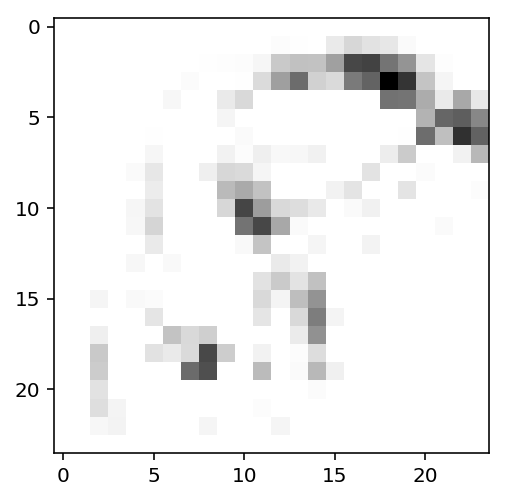

In [61]:
plt.imshow(layer_output[50][:, :, -1], cmap='Greys')

In [ ]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
for i in range(nrows*ncols):
    ax[i//ncols, i%ncols].imshow(X_train[i, :].reshape(28, 28), cmap='Greys')
    ax[i//ncols, i%ncols].set_title('Label: {}'.format(int(y_train[i])), fontsize=16)
plt.tight_layout()

## Evaluate Loss and Accuracy on Validation Set
### Calculate Final Loss and Accuracy

In [14]:
X_val = X_val.astype('float32')/255.
final_loss, final_acc = classifier.evaluate(X_val, y_val, verbose=0)
print('Final loss: {0:.4f}\nFinal accuracy: {1:.4f}'.format(final_loss, final_acc))

Final loss: 0.0240
Final accuracy: 0.9962


### Plotting Loss and Accuracy vs Number of Epochs

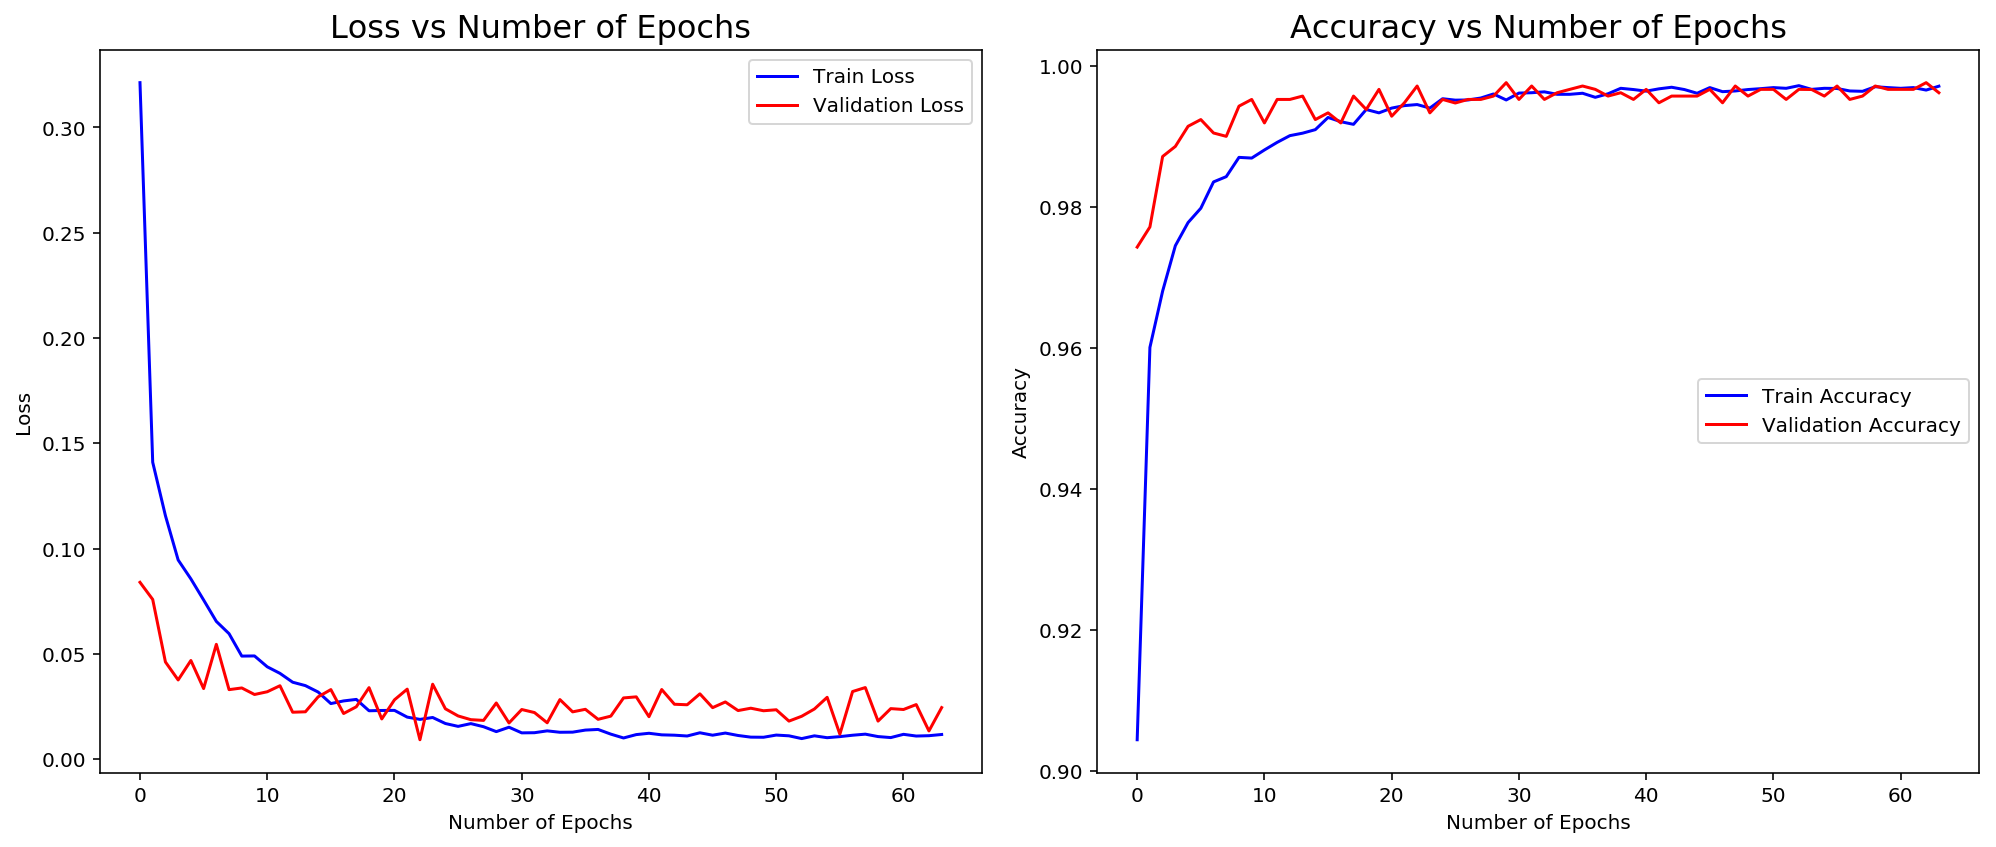

In [15]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(hist.history['loss'], color='b', label='Train Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.title('Loss vs Number of Epochs', fontsize=16)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(hist.history['acc'], color='b', label='Train Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.title('Accuracy vs Number of Epochs', fontsize=16)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.tight_layout()

### Confusion Matrix and Classification Report

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = classifier.predict_classes(X_val, batch_size=batch_size, verbose=0)
y_true = np.argmax(y_val, axis=1)
print(confusion_matrix(y_true, y_pred), '\n')
print(classification_report(y_true, y_pred))

[[191   0   0   0   1   0   1   0   0   0]
 [  0 228   0   0   0   0   1   0   0   0]
 [  1   0 193   0   0   0   0   0   0   0]
 [  0   0   0 239   0   0   0   1   0   0]
 [  0   0   0   0 215   0   0   0   0   0]
 [  0   0   0   0   0 180   0   0   0   0]
 [  0   0   0   0   0   0 191   0   0   0]
 [  0   0   0   0   0   0   0 212   0   0]
 [  0   0   1   0   0   0   0   0 203   0]
 [  0   0   0   0   0   0   0   0   2 240]] 

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       193
          1       1.00      1.00      1.00       229
          2       0.99      0.99      0.99       194
          3       1.00      1.00      1.00       240
          4       1.00      1.00      1.00       215
          5       1.00      1.00      1.00       180
          6       0.99      1.00      0.99       191
          7       1.00      1.00      1.00       212
          8       0.99      1.00      0.99       204
          9       1.00      0.99    

### Plotting the Wrong Predictions

There are 8 misclassified digits.


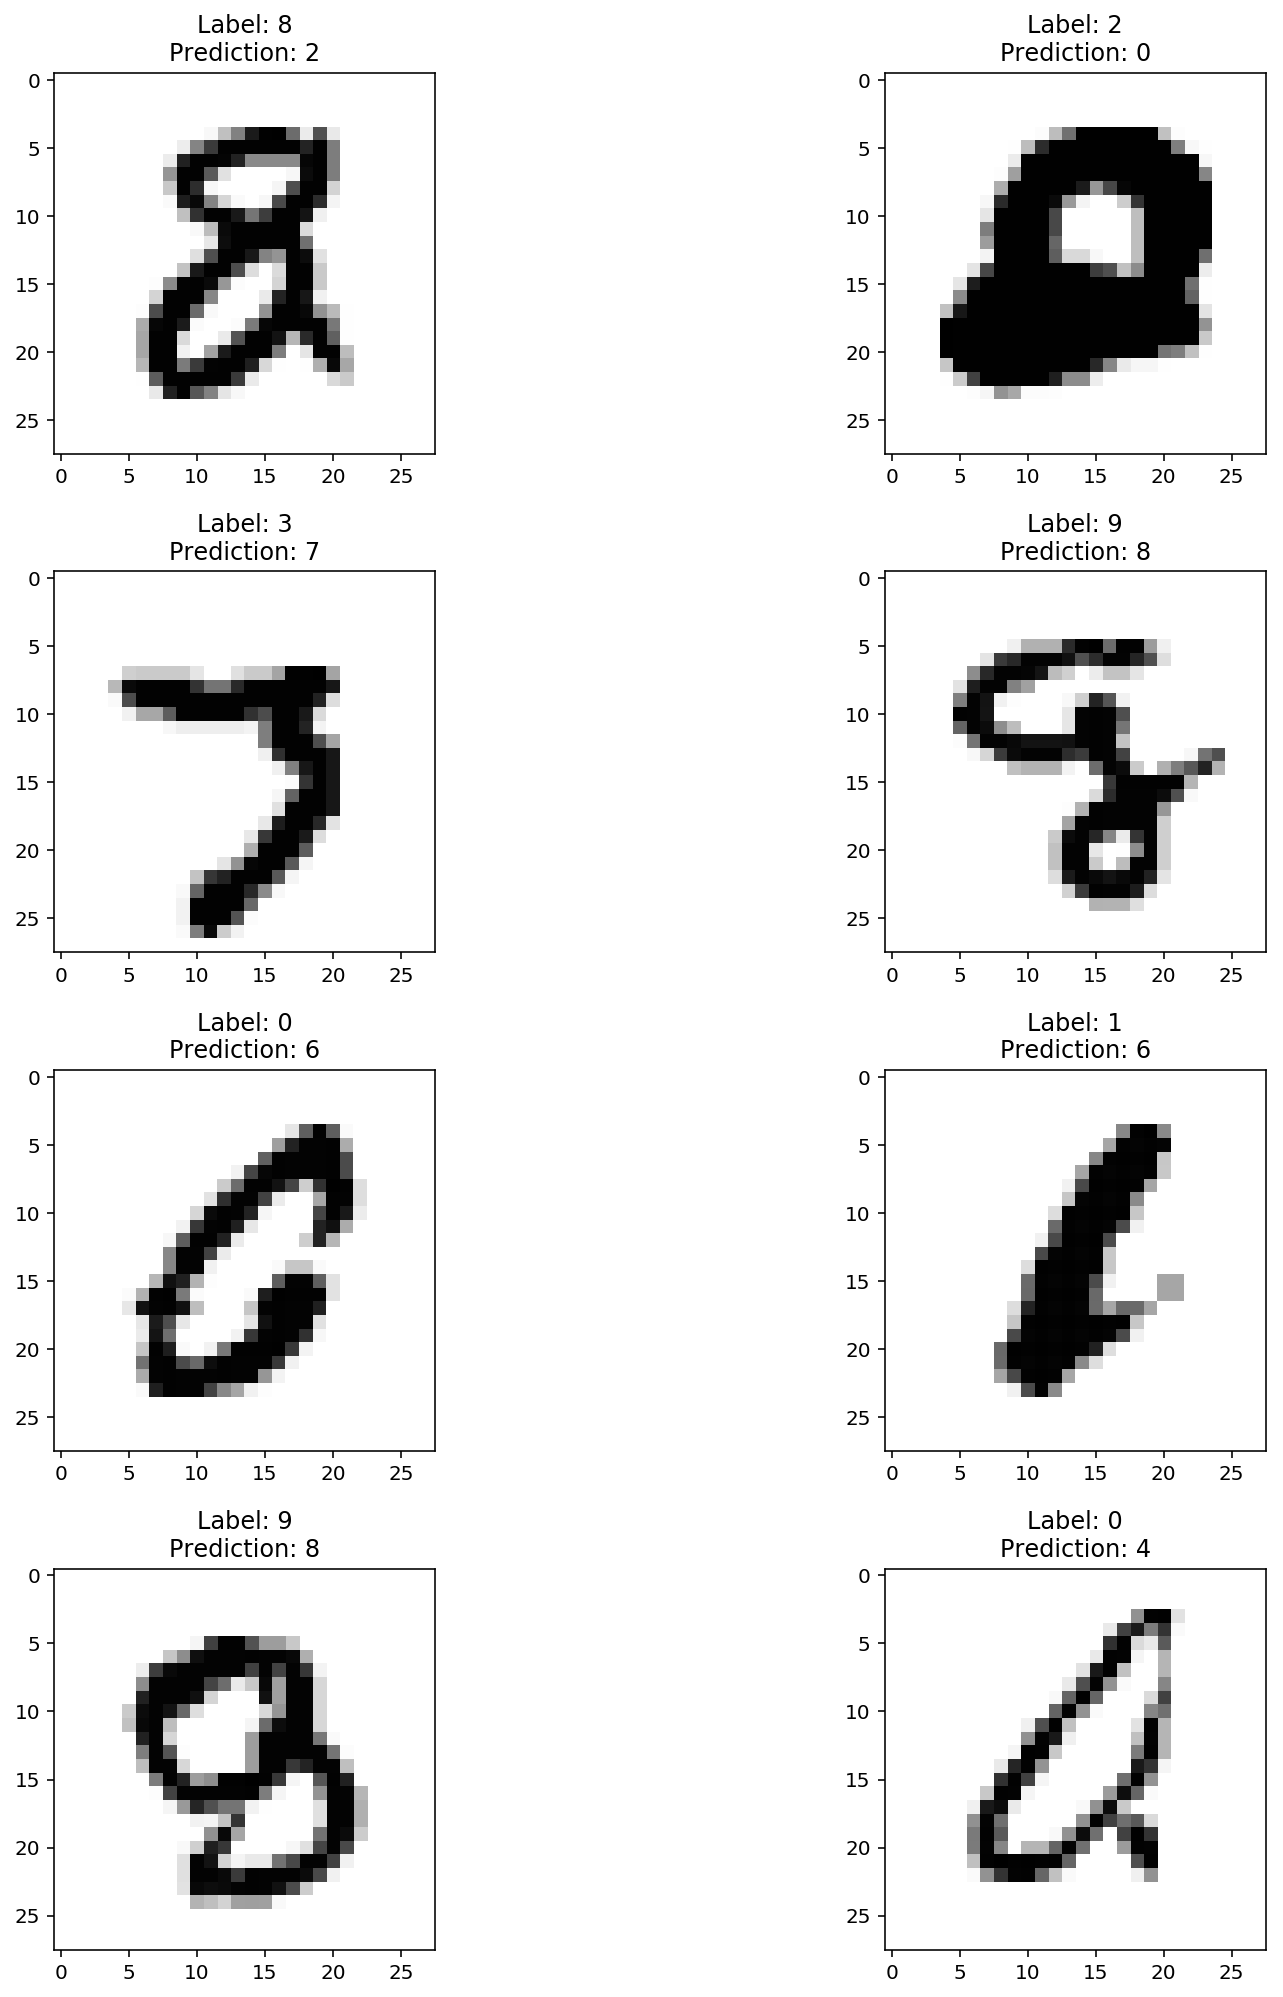

In [19]:
diff = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        diff.append(i)
print('There are {} misclassified digits.'.format(len(diff)))

ncols = 2
nrows = (len(diff)//ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
for i in range(len(diff)):
    ax[i//ncols, i%ncols].imshow(X_val[diff[i], :, :, -1], cmap='Greys')
    ax[i//ncols, i%ncols].set_title('Label: {}\nPrediction: {}'.format(int(y_true[diff[i]]), 
                                                                       int(y_pred[diff[i]])), fontsize=12)
plt.tight_layout()

As you can see there are quite a few parameters that could be tweaked (number of layers, number of filters, Dropout parameters, learning rate, augmentation settings). This is often done with trial and error, and there is no easy shortcut.

Getting convergence should not be a problem, unless you use an extremely large learning rate. It's easy, however, to create a net that overfits, with perfect results on the training set and very poor results on the validation data. If this happens, you could try increasing the Dropout parameters, increase augmentation, or perhaps stop training earlier. If you instead wants to increase accuracy, try adding on two more layers, or increase the number of filters.

## Make Predictions on Test Set

In [20]:
predictions = classifier.predict_classes(X_test, batch_size=batch_size)

28000/28000 [==============================] - 101s   


### Check Predictions vs Actual Digits on Test Set

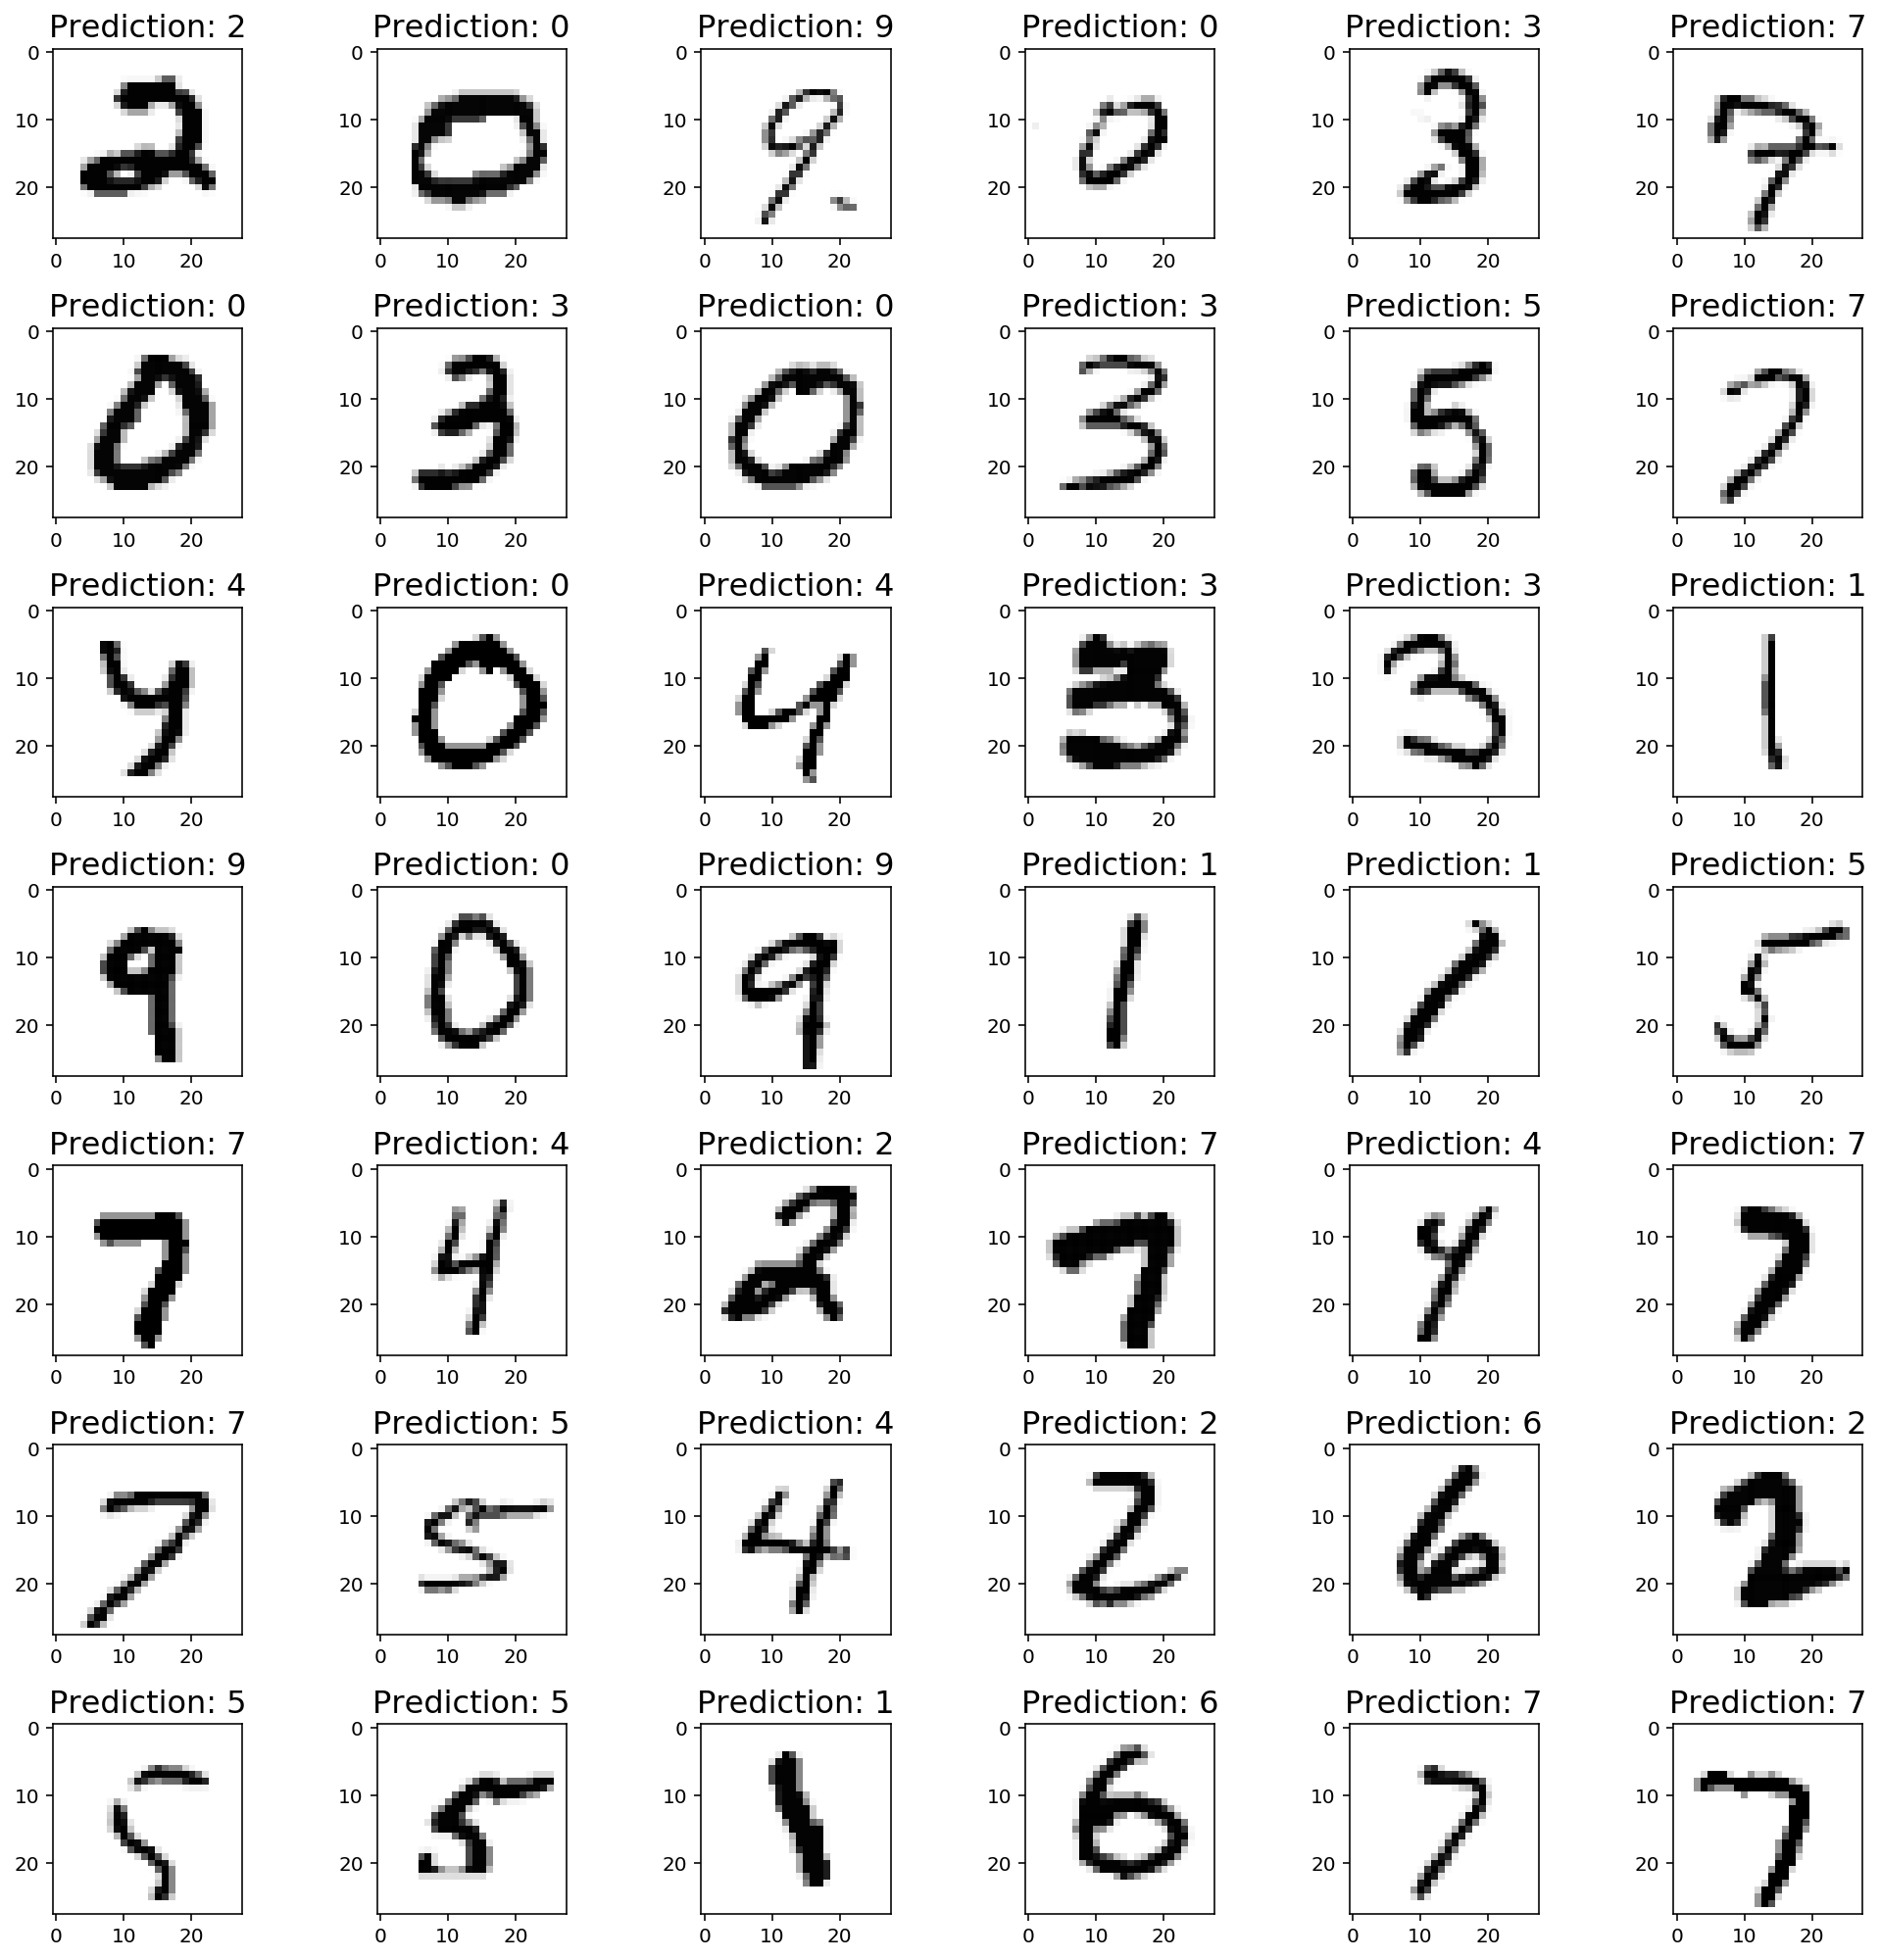

In [21]:
nrows = 7
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
for i in range(nrows*ncols):
    ax[i//ncols, i%ncols].imshow(X_test[i, :].reshape(28, 28), cmap='Greys')
    ax[i//ncols, i%ncols].set_title('Prediction: {}'.format(int(predictions[i])), fontsize=16)
plt.tight_layout()

In [22]:
pd.DataFrame({"ImageId": list(range(1, len(predictions) + 1)), 
              "Label": predictions}
            ).to_csv("submission.csv", index=False, header=True)